In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# Load the data
filepath = '/kaggle/input/dataset-eu-3k-5k/DataSet_EU_3k_5k.xlsx'
df = pd.read_excel(filepath)

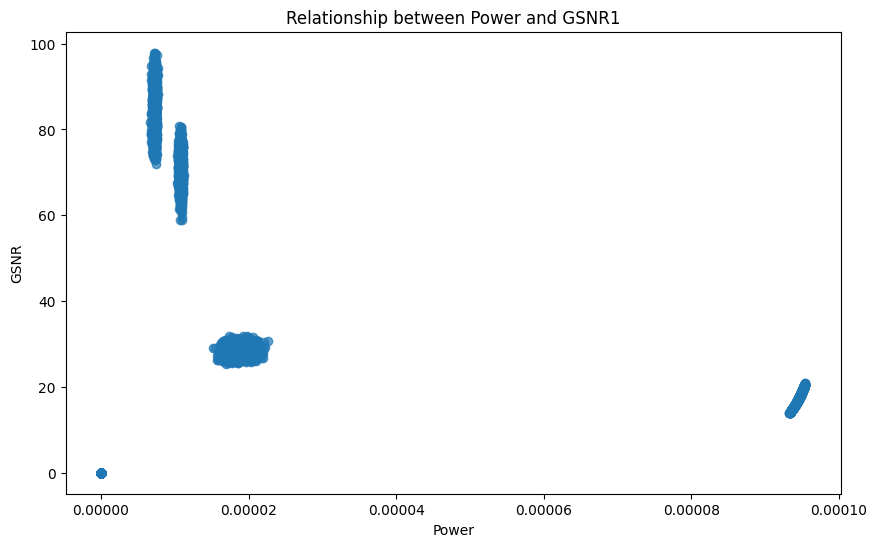

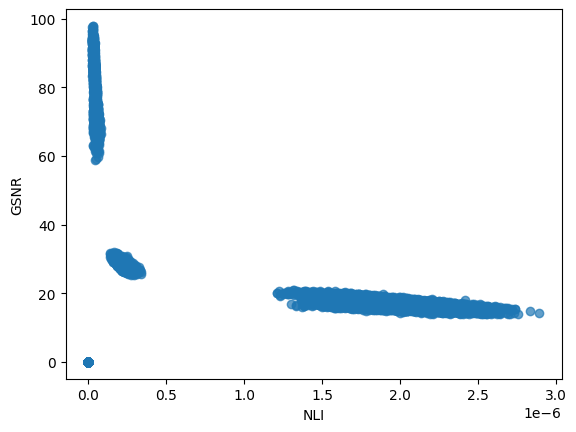

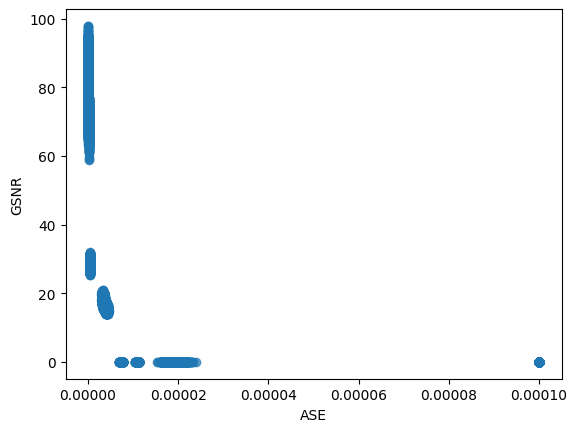

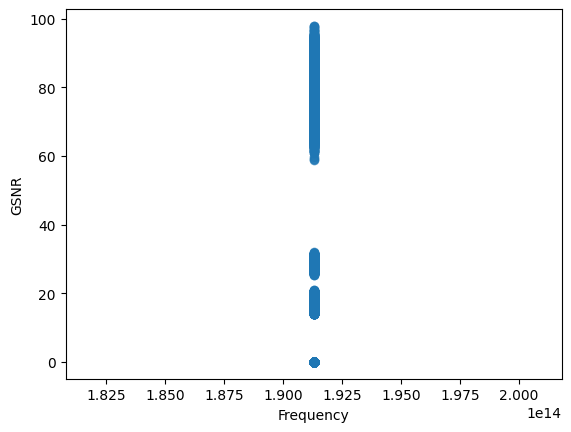

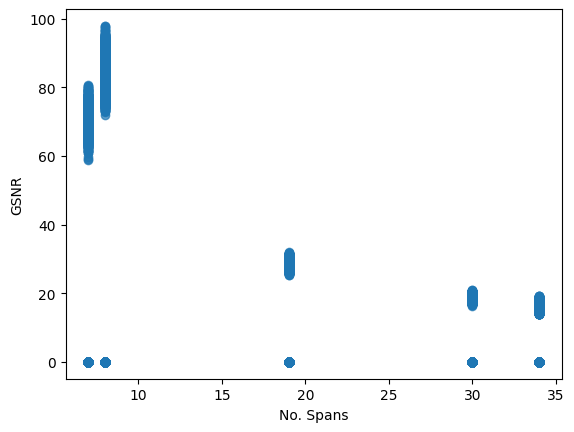

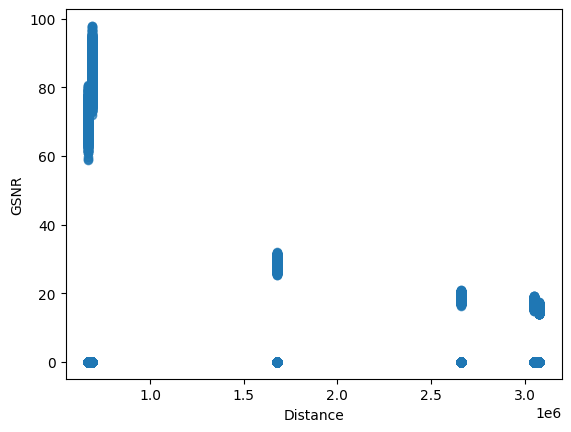

In [4]:
# Fill missing values with the mean of each column
df.fillna(df.mean(), inplace=True)
# Example columns: 'Power' and 'GSNR1'
plt.figure(figsize=(10, 6))
plt.scatter(df['Power_1'], df['GSNR_1'], alpha=0.7)
plt.title('Relationship between Power and GSNR1')
plt.xlabel('Power')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df['NLI_1'], df['GSNR_1'], alpha=0.7)
plt.xlabel('NLI')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df['ASE_1'], df['GSNR_1'], alpha=0.7)
plt.xlabel('ASE')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df['frequency_1'], df['GSNR_1'], alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df['No. Spans'], df['GSNR_1'], alpha=0.7)
plt.xlabel('No. Spans')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df['Total Distance(m)'], df['GSNR_1'], alpha=0.7)
plt.xlabel('Distance')
plt.ylabel('GSNR')
plt.show()
# Select numerical columns for normalization
numerical_cols = df.select_dtypes(include=[float, int]).columns
data = df[numerical_cols].values

target = df['GSNR_1']

# Convert to PyTorch tensor
target_tensor = torch.tensor(target, dtype=torch.float32)

# Calculate the mean and standard deviation, handle zero std
mean = target_tensor.mean(dim=0, keepdim=True)
std = target_tensor.std(dim=0, keepdim=True)
std[std == 0] = 1  # Prevent division by zero

# Perform normalization
normalized_tensor = (target_tensor - mean) / std

# Identify existing GSNR columns
gsnr_columns = [col for col in df.columns if 'GSNR' in col]

# Drop existing GSNR columns
features = df.drop(columns=gsnr_columns)

# Select numerical columns for normalization
numerical_cols = features.select_dtypes(include=[float, int]).columns
features_data = features[numerical_cols].values

# Normalize features
features_mean = features_data.mean(axis=0)
features_std = features_data.std(axis=0)
features_std[features_std == 0] = 1  # Prevent division by zero
normalized_features = (features_data - features_mean) / features_std

features_tensor = torch.tensor(normalized_features, dtype=torch.float32)

from torch.utils.data import Dataset, DataLoader, random_split

class MyDataset(Dataset):
  def __init__(self, features, target):
    self.features = features
    self.target = target

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.target[idx]
dataset = MyDataset(features_tensor,target_tensor)
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_set , val_set , test_set = random_split(dataset,[train_size,val_size,test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
import torch.nn.functional as F
input_dim = features_tensor.shape[1]
output_dim = 1


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torchvision import models

class ResNetForTabular(nn.Module):
    def __init__(self, input_dim):
        super(ResNetForTabular, self).__init__()
        self.base_model = models.resnet50(weights=None)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(-1)  # Adapt input dimensions for ResNet
        x = self.base_model(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Dummy example for dataset creation
# Assuming features_tensor and target_tensor are defined
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Replace these with your actual tensors
features_tensor = torch.randn(1000, 10)
target_tensor = torch.randn(1000)

dataset = CustomDataset(features_tensor, target_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
input_dim = features_tensor.shape[1]  # Update with your input dimension
model = ResNetForTabular(input_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for features, target in val_loader:
                outputs = model(features)
                loss = criterion(outputs, target.unsqueeze(1))
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 1.3588, Val Loss: 1.0882
Epoch 2/50, Train Loss: 1.0832, Val Loss: 1.2652
Epoch 3/50, Train Loss: 1.0586, Val Loss: 1.0801
Epoch 4/50, Train Loss: 1.0367, Val Loss: 1.0872
Epoch 5/50, Train Loss: 1.0166, Val Loss: 1.0821
Epoch 6/50, Train Loss: 1.0018, Val Loss: 1.0976
Epoch 7/50, Train Loss: 0.9530, Val Loss: 1.1822
Epoch 8/50, Train Loss: 1.0345, Val Loss: 1.0893
Epoch 9/50, Train Loss: 1.0309, Val Loss: 1.0943
Epoch 10/50, Train Loss: 1.0112, Val Loss: 1.1579
Epoch 11/50, Train Loss: 0.9924, Val Loss: 1.0867
Epoch 12/50, Train Loss: 0.9436, Val Loss: 1.0856
Epoch 13/50, Train Loss: 1.0177, Val Loss: 1.0834
Epoch 14/50, Train Loss: 1.0127, Val Loss: 1.0961
Epoch 15/50, Train Loss: 0.9920, Val Loss: 1.1273
Epoch 16/50, Train Loss: 0.9464, Val Loss: 1.0885
Epoch 17/50, Train Loss: 0.9801, Val Loss: 1.1443
Epoch 18/50, Train Loss: 0.9278, Val Loss: 1.2604
Epoch 19/50, Train Loss: 0.8080, Val Loss: 1.1825
Epoch 20/50, Train Loss: 0.7149, Val Loss: 1.6330
Epoch 21/

In [6]:
# Function to evaluate model performance on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    val_targets = []
    val_predictions = []
    with torch.no_grad():
        for features, target in val_loader:
            outputs = model(features)
            val_predictions.extend(outputs.squeeze().cpu().numpy())
            val_targets.extend(target.cpu().numpy())

    mse = mean_squared_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)
    mae = mean_absolute_error(val_targets, val_predictions)

    print(f'Validation MSE: {mse:.4f}')
    print(f'Validation R²: {r2:.4f}')
    print(f'Validation MAE: {mae:.4f}')
    return mse, r2, mae


# Evaluate the model
evaluate_model(model, val_loader)

Validation MSE: 1.4174
Validation R²: -0.3533
Validation MAE: 0.9590


(1.417416, -0.3532977984347587, 0.9589966)

In [7]:
import pandas as pd
filepath = '/kaggle/input/dataset-usa-3k-5k-xlsx/DataSet_USA_3k_5k.xlsx'
df1 = pd.read_excel(filepath)


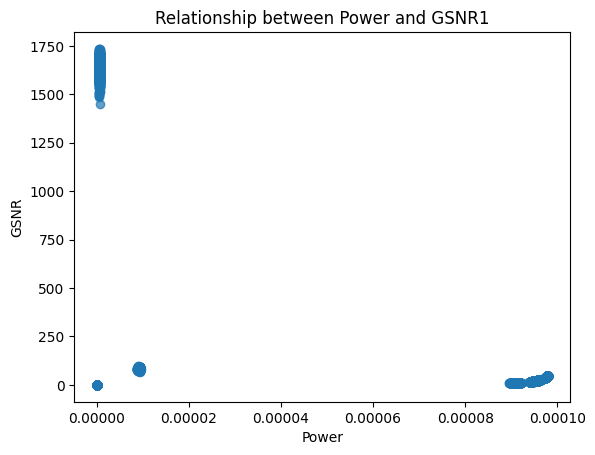

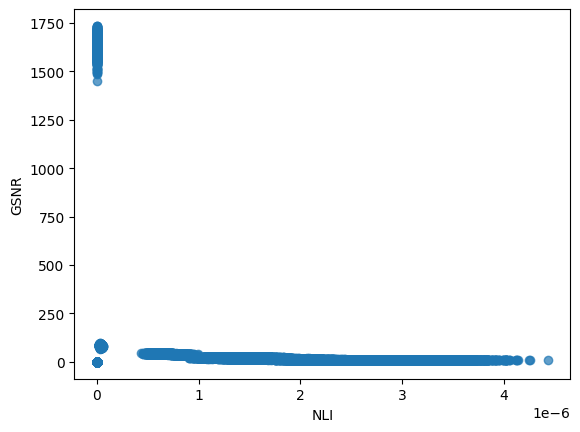

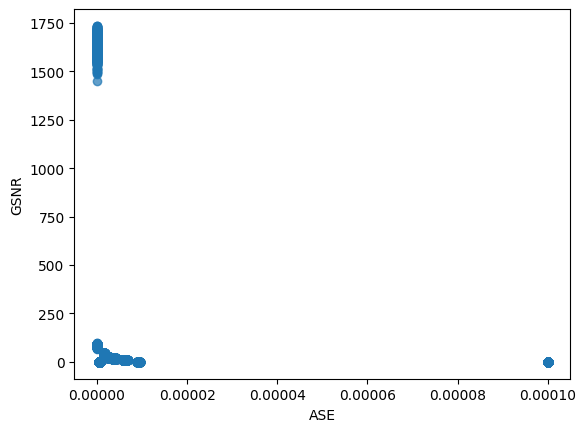

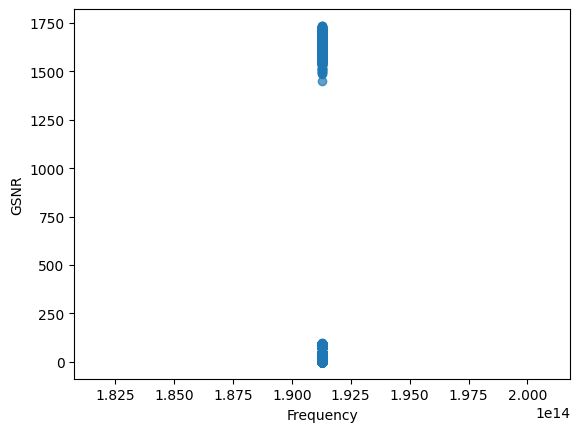

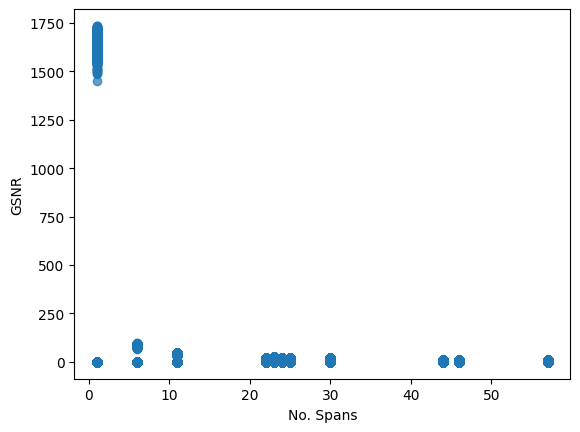

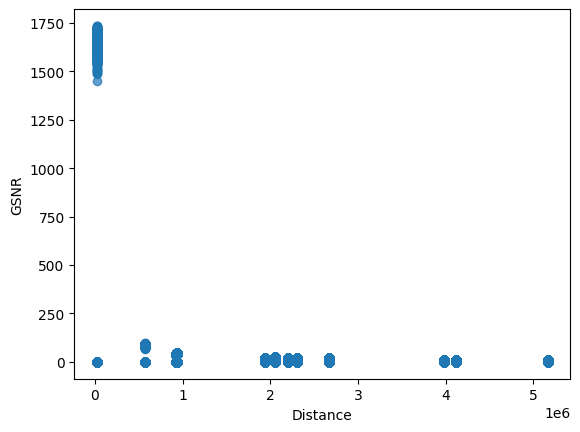

In [8]:
# Fill missing values with the mean of each column
df1.dropna()
# Example columns: 'Power' and 'GSNR1'
plt.scatter(df1['Power_1'], df1['GSNR_1'], alpha=0.7)
plt.title('Relationship between Power and GSNR1')
plt.xlabel('Power')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df1['NLI_1'], df1['GSNR_1'], alpha=0.7)
plt.xlabel('NLI')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df1['ASE_1'], df1['GSNR_1'], alpha=0.7)
plt.xlabel('ASE')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df1['frequency_1'], df1['GSNR_1'], alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df1['No. Spans'], df1['GSNR_1'], alpha=0.7)
plt.xlabel('No. Spans')
plt.ylabel('GSNR')
plt.show()

plt.scatter(df1['Total Distance(m)'], df1['GSNR_1'], alpha=0.7)
plt.xlabel('Distance')
plt.ylabel('GSNR')
plt.show()
# Select numerical columns for normalization
numerical_cols = df1.select_dtypes(include=[float, int]).columns
data = df1[numerical_cols].values

target = df1['GSNR_1']

# Convert to PyTorch tensor
target_tensor1 = torch.tensor(target, dtype=torch.float32)

# Calculate the mean and standard deviation, handle zero std
mean = target_tensor1.mean(dim=0, keepdim=True)
std = target_tensor1.std(dim=0, keepdim=True)
std[std == 0] = 1  # Prevent division by zero

# Perform normalization
normalized_tensor = (target_tensor - mean) / std

# Identify existing GSNR columns
gsnr_columns = [col for col in df1.columns if 'GSNR' in col]

# Drop existing GSNR columns
features = df1.drop(columns=gsnr_columns)

# Select numerical columns for normalization
numerical_cols = features.select_dtypes(include=[float, int]).columns
features_data = features[numerical_cols].values

# Normalize features
features_mean = features_data.mean(axis=0)
features_std = features_data.std(axis=0)
features_std[features_std == 0] = 1  # Prevent division by zero
normalized_features = (features_data - features_mean) / features_std

features_tensor1 = torch.tensor(normalized_features, dtype=torch.float32)

from torch.utils.data import Dataset, DataLoader, random_split

class MyDataset(Dataset):
  def __init__(self, features, target):
    self.features = features
    self.target = target

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.target[idx]
dataset1 = MyDataset(features_tensor1,target_tensor1)
train_size = int(0.7 * len(dataset1))
test_size = int(0.15 * len(dataset1))
val_size = len(dataset1) - train_size - test_size
train_set1 , val_set1 , test_set1 = random_split(dataset1,[train_size,val_size,test_size])
train_loader1 = DataLoader(train_set1, batch_size=32, shuffle=True)
val_loader1 = DataLoader(val_set1, batch_size=32, shuffle=False)
test_loader1 = DataLoader(test_set1, batch_size=32, shuffle=False)
# Saving trained model# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


In [ ]:
# Freeze initial layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Replace final layers
model.fc1 = nn.Linear(128, 64)
model.fc2 = nn.Linear(64, 1)

# Train only the new layers
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_feature_extraction(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}')
# Train new layers
train_feature_extraction(model, train_loader1, criterion, optimizer, epochs=50)
# Evaluate model performance
evaluate_model(model, usa_val_loader1)

Epoch 1/50, Train Loss: 95397.9142
Epoch 2/50, Train Loss: 83090.0997
Epoch 3/50, Train Loss: 67257.6600
Epoch 4/50, Train Loss: 61078.4226
Epoch 5/50, Train Loss: 59698.1277
Epoch 6/50, Train Loss: 58101.6788
Epoch 7/50, Train Loss: 59172.6959
Epoch 8/50, Train Loss: 58680.9663
Epoch 9/50, Train Loss: 58129.9122
Epoch 10/50, Train Loss: 58155.9477
Epoch 11/50, Train Loss: 57931.8357
Epoch 12/50, Train Loss: 57713.3690
Epoch 13/50, Train Loss: 57628.1279
Epoch 14/50, Train Loss: 58450.1217
Epoch 15/50, Train Loss: 57570.3167


In [ ]:
# Unfreeze some layers for fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = True

# Reinitialize optimizer to update all parameters
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function for fine-tuning
def train_fine_tuning(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for features, target in val_loader:
                outputs = model(features)
                loss = criterion(outputs, target.unsqueeze(1))
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Fine-tune the entire model
train_fine_tuning(model, usa_train_loader, usa_val_loader, criterion, optimizer, epochs=50)

# Evaluate fine-tuned model
evaluate_model(model, usa_val_loader)
